In [20]:
from nbformat import reads, NO_CONVERT
from nbconvert import PythonExporter
def code_extractor(jpt):
    nb = reads(jpt, NO_CONVERT)
    exporter = PythonExporter()
    source, meta = exporter.from_notebook_node(nb)
    return source

In [21]:
import imp
Matchmaker = imp.load_source('name', '../matchmaker.py')
import ast
def function_matching(nb):
    tree = ast.parse(nb)
    mm = Matchmaker.Matchmaker()
    mm.visit(tree)
    matchs = mm.matching()
    return matchs

# Matching the functions 1st version

In [ ]:
from pydriller import RepositoryMining
import difflib
import pandas as pd

def repo_matching(repo, commit, path):
    for c in RepositoryMining(repo, single = commit).traverse_commits():
        for modified_files in c.modifications:
            if modified_files.new_path == path:
                try:
                    before = code_extractor(modified_files.source_code_before)
                except TypeError:
                    before = ""
                lines_b = before.strip().splitlines()
                new = code_extractor(modified_files.source_code)
                lines_n = new.strip().splitlines()
                
                diff = difflib.unified_diff(lines_b, lines_n, fromfile='before', tofile='new', lineterm='', n=0)
                lines = list(diff)[2:]
                lineno = 0
                changes = pd.DataFrame(columns = ['repo','path','author','commit','line','code'])
                for line in lines:
                    prefix = '@@'
                    if line.startswith(prefix):
                        s = line[line.find("+"):]
                        try:
                            lineno = int(s[1:s.find(",")])
                        except:
                            lineno = int(s[1:s.find(" ")])
                    else:
                        if line.startswith("+"):
                            changes = changes.append({"repo": c.project_name, 
                                                      "path": modified_files.new_path,
                                                      "author": c.author.email,
                                                      "commit": c.hash,
                                                      "line": lineno,
                                                      "code": line[1:]}, ignore_index= True)
                            lineno += 1
                matches = function_matching(new)
                result = pd.merge(matches, changes, how = 'inner', on= "line")
                return result

# Test

In [ ]:
from pydriller import RepositoryMining, GitRepository
repo = "/home/ubuntu/repos/abulbasar/machine-learning"
test = RepositoryMining(repo)
for commit in test.traverse_commits():
    for file in commit.modifications:
        print(commit.hash + ' at ' + file.new_path)

In [ ]:
repo = "/home/ubuntu/repos/abulbasar/machine-learning"
path = "01 Neural Network using Numpy.ipynb"
commit = "df41ae028af5a445ec41a94925ac98ad2ccdea01"

m = repo_matching(repo = repo,path = path,commit = commit)


In [ ]:
m.head()

# Running through all commits 1st version

In [ ]:
import pandas as pd
import ast
import csv
# incresing the csv field size
import ctypes
csv.field_size_limit(int(ctypes.c_ulong(-1).value // 2))
failed = []
fields = ['line','function','package','class','repo','path', 'author', 'commit','code']
repo_path = "/home/ubuntu/repos/"
with open('../data/commits_bigquery.csv',"r", encoding="utf8") as csvfile:
    with open("../data/repo_function_matched.csv", "w", encoding="utf8") as newfile:
        data = csv.DictReader(csvfile)
        writer = csv.DictWriter(newfile, fieldnames=fields)
        writer.writeheader()
        for row in data:
            try:
                commit = row['commit']
                repo = row['repo']
                path = row['path']
                #path = path.replace("/", "\\")
                repo = repo_path + repo
                matched = repo_matching(repo, commit, path)
                matched.to_csv(newfile, header=False, index= False)
            except KeyboardInterrupt:
                break
            except Exception as e: 
                failed.append(e)
                #print(e)
                #break
import pickle

with open('../data/fails', 'wb') as fp:
    pickle.dump(failed, fp)

In [ ]:
failed

# Prepare data 2nd version

In [ ]:
import pandas as pd
import numpy as np
import os.path
from os import path

df = pd.read_csv('../data/commits_bigquery.csv')
df = df.drop(df.columns[0], axis = 1)

repos = df.repo.unique()
add_path = np.vectorize(lambda x: "/home/ubuntu/repos/" +x)
repos = add_path(repos)
repos = repos.tolist()
for i in repos:
    if not path.exists(i):
        repos.remove(i)

commits = df.commit.unique().tolist()

paths = df[['commit','path']].groupby('commit')['path'].apply(list)

In [ ]:
len(repos)

# 2nd version

In [ ]:
from pydriller import RepositoryMining
import difflib
import pandas as pd
import csv
#inspect all repos and commits
failed = []
fields = ['line','function','package','class','repo','path', 'author', 'commit','code']
newfile = open("../data/repo_function_matched.csv", "w", encoding="utf8")
writer = csv.DictWriter(newfile, fieldnames=fields)
writer.writeheader()
    
for c in RepositoryMining(repos, only_no_merge=True, only_commits=commits).traverse_commits():
    for modified_files in c.modifications:
        try:
            if modified_files.new_path in paths[c.hash]:
                try:
                    before = code_extractor(modified_files.source_code_before)
                except TypeError:
                    before = ""
                lines_b = before.strip().splitlines()
                new = code_extractor(modified_files.source_code)
                lines_n = new.strip().splitlines()
                
                diff = difflib.unified_diff(lines_b, lines_n, fromfile='before', tofile='new', lineterm='', n=0)
                lines = list(diff)[2:]
                lineno = 0
                changes = pd.DataFrame(columns = ['repo','path','author','commit','line','code'])
                for line in lines:
                    prefix = '@@'
                    if line.startswith(prefix):
                        s = line[line.find("+"):]
                        try:
                            lineno = int(s[1:s.find(",")])
                        except:
                            lineno = int(s[1:s.find(" ")])
                    else:
                        if line.startswith("+"):
                            changes = changes.append({"repo": c.project_name, 
                                                      "path": modified_files.new_path,
                                                      "author": c.author.email,
                                                      "commit": c.hash,
                                                      "line": lineno,
                                                      "code": line[1:]}, ignore_index= True)
                            lineno += 1
                matches = function_matching(new)
                result = pd.merge(matches, changes, how = 'inner', on= "line")
                result.to_csv(newfile, header=False, index= False)
        except KeyboardInterrupt:
            break
        except Exception as e: 
            failed.append([c.project_name,modified_files.new_path,e])

newfile.close()
                
import pickle

with open('../data/fails', 'wb') as fp:
    pickle.dump(failed, fp)

# Preparing data 3rd try

In [22]:
import pandas as pd
import numpy as np
import os.path
from os import path

df = pd.read_csv('../data/commits_bigquery.csv')
df = df.drop(df.columns[0], axis = 1)

repos = df.repo.unique()
#add_path = np.vectorize(lambda x: "/home/ubuntu/repos/" +x)
#repos = add_path(repos)
repos = repos.tolist()
for i in repos:
    if not path.exists(i):
        repos.remove(i)
folder = "/home/ubuntu/repos/"
commits = df[['repo','commit']].groupby('repo')['commit'].apply(list)
paths = df[['commit','path']].groupby('commit')['path'].apply(list)

# Running 3rd try

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': "alt.Chart(df).mark_line().encode(\n    x='strain',\n    y='stress'\n)", 'outputs': [{'metadata': {'jupyter-vega': '#3b49a8c3-8efb-40ef-a756-0ecac4bca769'}, 'output_type': 'execute_result', 'data': {'text/html': '<div class="vega-embed" id="3b49a8c3-8efb-40ef-a756-0ecac4bca769"></div>\n\n<style>\n.vega-embed svg, .vega-embed canvas {\n  border: 1px dotted gray;\n}\n\n.vega-embed .vega-

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {'collapsed': False, 'papermill': {'start_time': '2018-02-06T17:00:59.446053', 'end_time': '2018-02-06T17:00:59.500179', 'duration': 0.054126, 'status': 'completed', 'exception': False}, 'tags': []}, 'cell_type': 'code', 'source': 'helpers.calc_g2d_pair_counts(pg)', 'outputs': [{'metadata': {}, 'output_type': 'execute_result', 'data': {'text/plain': '<IPython.core.display.HTML object>', 'text/html': '<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>field_pair</th>\n      <th>unique_associations</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>[gene_id, disease_efo_i

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': 'DataStructureVisualization(BinarySearchTree).run()'} is not valid under any of the given schemas

Failed validating 'oneOf' in schema['properties']['cells']['items']:
    {'oneOf': [{'$ref': '#/definitions/raw_cell'},
               {'$ref': '#/definitions/markdown_cell'},
               {'$ref': '#/definitions/code_cell'}],
     'type': 'object'}

On instance['cells'][9]:
    {'cell_type': 'code',
     'metadata': {},
     'source': 'DataStructureVisualization(BinarySearchTree).run()'}

During handling of the above exception, another exception occurred:

Traceback (most recent call last

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': "fig, ax = plt.subplots()\nget_line(ax, 'Cu', 12)", 'outputs': [{'metadata': {}}, {'output_type': 'execute_result', 'metadata': {}, 'data': {'text/html': ''}}], 'execution_count': 8} is not valid under any of the given schemas

Failed validating 'oneOf' in schema['properties']['cells']['items']:
    {'oneOf': [{'$ref': '#/definitions/raw_cell'},
               {'$ref': '#/definitions/markdown_cell'},
               {'$ref': '#/definitions/code_cell'}],
     'type': 'object'}

On instance['cells'][15]['outputs'][0]:
    {'cell_type': 'code',
     'execution_count': 8,
     'metadata': {},

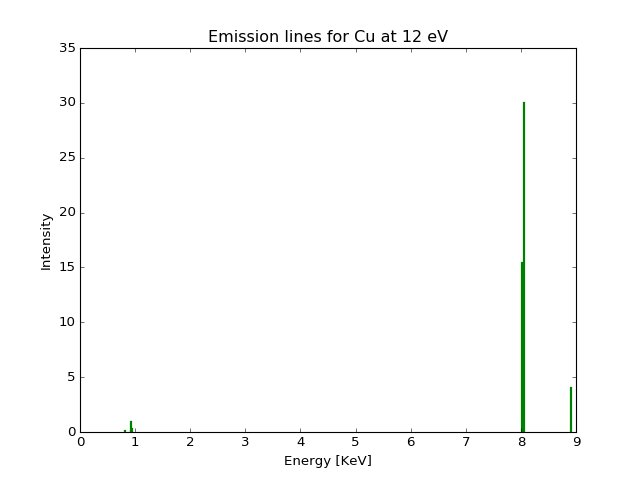
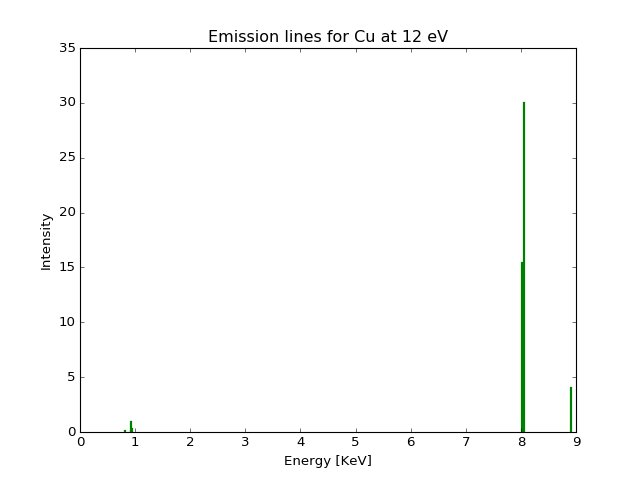

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': "ml = ModelMaq(kaq=[1, 2], z=[10, 5, 4, 0], c=20)\nxy = [(-5, 0), (0, 0), (5, 0), (5, 8), (-5, 8)]\np1 = PolygonInhomMaq(ml, xy=xy, kaq=[0.2, 8], z=[11, 10, 5, 4, 0], \n                     c=[2, 20], topboundary='semi', hstar=1.0, order=3, ndeg=1)\nw = Well(ml, xw=0, yw=-10, Qw=100, layers=1)\nrf = Constant(ml, xr=0, yr=-100, hr=2)\nml.solve()\n\nml.contour([-10, 10, -15, 10], 50, [0, 1], 30)", 'outputs': [{'name': 'stdout', 'output_type': 'stream', 'text': 'Number of elements, Number of equations: 13 , 81\n.............\nsolution complete\n'}, {'metadata': {}, 'output_type': 'display_da
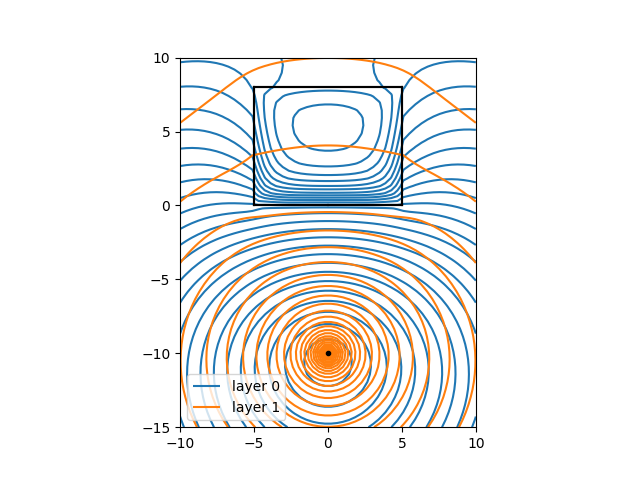
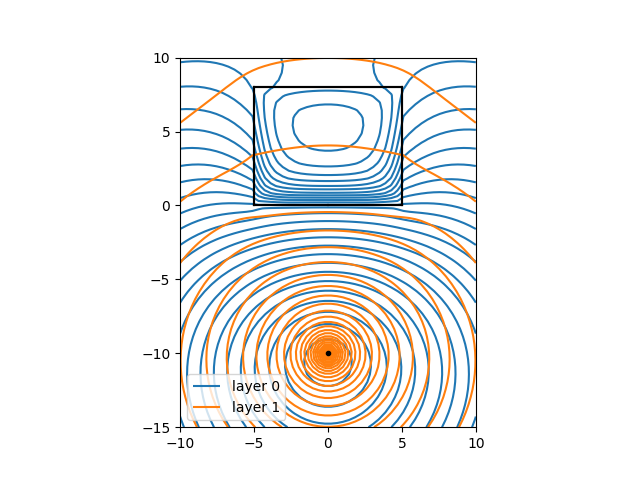

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': "#  Let's visualize these results\nplt.plot(df['T'], df['TypeC_calib_mV'], 'o', ms=0.5 )\nplt.xlabel('Temperature (K)')\nplt.ylabel('Type C calibrated emf (mV)')\n\n# Interesting. I cooled first to LN2 temperatures and then allowed the sample to heat up slowly by evaporating LN2\n# The data agrees fairly well (within ~3 K) between the heating and cooling curves. I didn't heat all the way back up.", 'outputs': [{'metadata': {}, 'output_type': 'display_data', 'data': {'text/plain': '<IPython.core.display.Javascript object>'}}, {'metadata': {}, 'output_type': 'execute_result', 'data': {'text
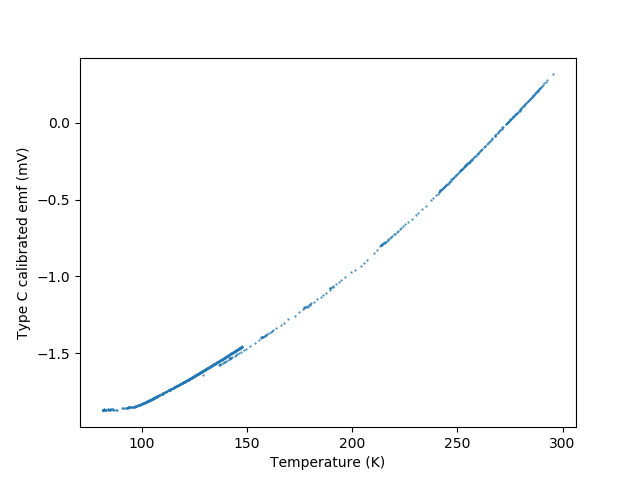
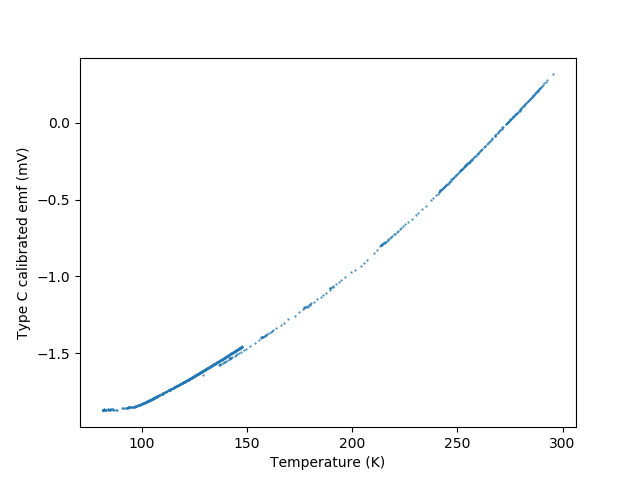

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': '', 'outputs': []} is not valid under any of the given schemas

Failed validating 'oneOf' in schema['properties']['worksheets']['items']['properties']['cells']['items']:
    {'oneOf': [{'$ref': '#/definitions/raw_cell'},
               {'$ref': '#/definitions/markdown_cell'},
               {'$ref': '#/definitions/heading_cell'},
               {'$ref': '#/definitions/code_cell'}],
     'type': 'object'}

On instance['worksheets'][0]['cells'][7]['prompt_number']:
    {'cell_type': 'code',
     'collapsed': False,
     'input':

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': 'os.chdir(\'/home/dlarochelle/mediacloud/screen_shots\')\n\ndirs = [\'top_10\', \'top_100\', \'top_1000\', \'all\']\nfor dir in dirs:\n    print "processing {}".format( dir )\n    os.chdir( dir )\n    with open (\'pop_queries.json\', \'rb\') as json_file:\n        json_string = json_file.read()\n        #print json_file.read()\n        popular_queries = json.loads( json_string )\n        for popular_query in popular_queries:\n            q0 = popular_query[ \'queries_id_0\' ]\n            q1 = popular_query[ \'queries_id_1\' ]

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': '%%px\n# Display its spectral portrait\nimport math\nrealRes = imagRes = 100\nportrait = El.SpectralPortrait(A,realRes,imagRes)\nEl.EntrywiseMap(portrait,math.log10)\nEl.Display(portrait,"spectral portrait of Fox-Li/Landau matrix")', 'outputs': [{'metadata': {}, 'output_type': 'display_data', 'text': '[output:1]'}, {'metada

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {'scrolled': False}, 'cell_type': 'code', 'source': "fig, ax = plt.subplots(2, 1, figsize=(9, 5), sharex=True)\ncml.channel_1.data.rx.plot(ax=ax[0])\ncml.channel_2.data.rx.plot(ax=ax[0])\ncml.channel_1.data.tx.plot(ax=ax[1])\ncml.channel_2.data.tx.plot(ax=ax[1])\n    \ncml_min_max.channel_1.data.rx_min.plot(ax=ax[0], color='C0', linestyle='--')\ncml_min_max.channel_2.data.rx_min.plot(ax=ax[0], color='C1', linestyle='--'
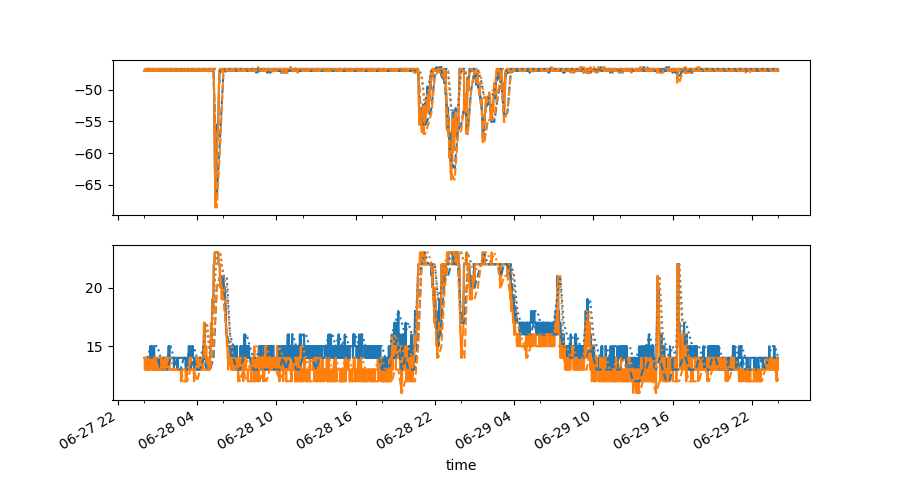
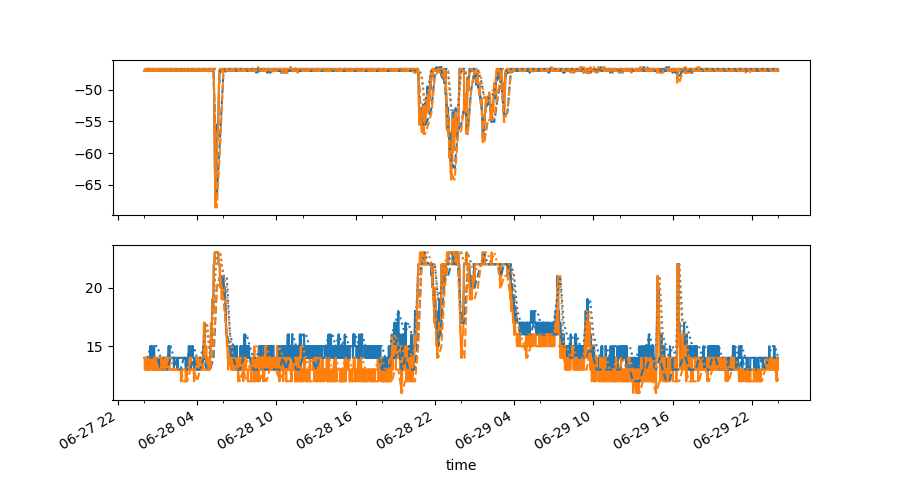

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'heading', 'source': 'Ubuntu Dataset v2 - Statistics', 'level': 1} is not valid under any of the given schemas

Failed validating 'oneOf' in schema['properties']['cells']['items']:
    {'oneOf': [{'$ref': '#/definitions/raw_cell'},
               {'$ref': '#/definitions/markdown_cell'},
               {'$ref': '#/definitions/code_cell'}],
     'type': 'object'}

On instance['cells'][0]:
    {'cell_type': 'heading',
     'level': 1,
     'metadata': {},
     'source': 'Ubuntu Dataset v2 - Statistics'}

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: 'nbformat_minor' is a required property

Failed validating 'required' in schema:
    {'$schema': 'http://json-schema.org/draft-04/schema#',
     'additionalProperties': True,
     'definitions': {'code_cell': {'additionalProperties': True,
                                   'description': 'Notebook code cell.',
                                   'properties': {'cell_type': {'description': 'String '
                                  

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'outputs': [], 'execution_count': None} is not valid under any of the given schemas

Failed validating 'oneOf' in schema['properties']['cells']['items']:
    {'oneOf': [{'$ref': '#/definitions/raw_cell'},
               {'$ref': '#/definitions/markdown_cell'},
               {'$ref': '#/definitions/code_cell'}],
     'type': 'object'}

On instance['cells'][11]:
    {'cell_type': 'code',
     'execution_count': None,
     'metadata': {},
     'outputs': []}

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': "for value in tracks['tracks']:\n    id = value['id']\n    df = pd.read_csv('https://envirocar.org/api/stable/tracks/'+id+'.csv', sep=';\\s+')\n    #print df.dtypes\n    \n    gps_speed = -99\n    speed = -99\n    \n    try:\n        gps_speed = df['GPS Speed(km/h)'].mean()  \n    except:\n        pass\n        \n    try: \n        speed = df['Speed(km/h)'].mean()\n    except:\n        pass\n        \n    print 'GPS Speed: {0:.2f}, Speed: {1:.2f}'.format(gps_speed, speed)\n    \n", 'outputs': [{'output_type': 'stream', 'text':

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': 'methane = Methane()\nmethane.visualize()', 'outputs': [{'output_type': 'execute_result', 'metadata': {}, 'data': {'text/html': '<div id="molecule_ec66f560-d0ed-478b-9b5d-0cb331aa556d"></div>\n           <script type="text/javascript">\n           require.config({baseUrl: \'/\',\n                           paths: {imolecule: [\'nbextensions/imolecule.min\', \'https://rawgit.com/patrickfuller/imolecule/master/imolecule/js/build/imolecule.min\']}});\n           require([\'imolecule\'], function () {\n               var $d = $(\'#molecule_ec66f560-d0ed-478b-9b5d-0cb331aa556d\');\n           

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': 'methane = Methane()\nmethane.visualize()', 'outputs': [{'output_type': 'execute_result', 'metadata': {}, 'data': {'text/html': '<div id="molecule_ec66f560-d0ed-478b-9b5d-0cb331aa556d"></div>\n           <script type="text/javascript">\n           require.config({baseUrl: \'/\',\n                           paths: {imolecule: [\'nbextensions/imolecule.min\', \'https://rawgit.com/patrickfuller/imolecule/master/imolecule/js/build/imolecule.min\']}});\n           require([\'imolecule\'], function () {\n               var $d = $(\'#molecule_ec66f560-d0ed-478b-9b5d-0cb331aa556d\');\n           

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': 'import time\n\nstart_time = int(round(time.time() * 1000))\n\n# now we have a file\ntext_file = sc.textFile("hdfs://hdfs-rpc.service.consul:31245/Accidents7904.csv")\n\n# getting the header as an array\nheader = text_file.first().split(",")\n\n# getting data\ndata = text_file \\\n   .map(lambda line: line.split(",")) \\\n   .filter(lambda w: w[header.index(\'Date\')] != \'Date\')\noutput = data.filter(lambda row: len(row[header.index(\'Date\')].strip().split("/")) == 3) \\\n   .map(lambda row: row[header.index(\'Date\')].stri

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v1 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v1 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'language': 'python', 'metadata': {}, 'prompt_number': '*', 'collapsed': False, 'cell_type': 'code', 'input': 'x= sum( np.array([1,2,3])==np.array([1,2,4]))', 'outputs': []} is not valid under any of the given schemas

Failed va

/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py:251: UserWarning: No schema for validating v2 notebooks
  warnings.warn("No schema for validating v%s notebooks" % version, UserWarning)
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': "from pyramid.arima import auto_arima\n\nfit = auto_arima(wineind, start_p=1, start_q=1, max_p=3, max_q=3, m=12,\n                 start_P=0, seasonal=True, n_jobs=-1, d=1, D=1, tra

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': 'plot_calibration_ac_led(ac_levels, charge, gain, pixel=100, show_fit=False)', 'outputs': [{'name': 'stderr', 'output_type': 'stream', 'text': '/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter a does not have initial value. Assume 0.\n/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.py:19: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.\n/home/alispach/.anaconda3/envs/digicampipe/lib/python3.5/site-packages/ipykernel_launcher.p

--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.5/site-packages/nbformat/validator.py", line 258, in validate
    return validator.validate(nbjson)
  File "/home/ubuntu/.local/lib/python3.5/site-packages/jsonschema/validators.py", line 353, in validate
    raise error
jsonschema.exceptions.ValidationError: {'metadata': {}, 'cell_type': 'code', 'source': 'hits_train = pd.read_csv("mlhep2015_starterkit/data/train.csv", index_col=\'global_id\')\nhits_train.head()', 'outputs': [{'output_type': 'execute_result', 'metadata': {}, 'data': {'text/html': '<div style="max-height:1000px;max-width:1500px;overflow:auto;">\n<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>event_id</th>\n      <th>wire_id</th>\n      <th>energy_deposit</th>\n      <th>relative_time</th>\n      <th>label</th>\n    </tr>\n    <tr>\n      <th>global_id</th>\n      <th></th>\n      <th></th>\n      <th></th>\n 

In [23]:
from pydriller import RepositoryMining
import difflib
import pandas as pd
import csv
#inspect all repos and commits
failed = []
fields = ['line','function','package','class','repo','path', 'author', 'commit','code']
newfile = open("../data/repo_function_matched.csv", "w", encoding="utf8")
writer = csv.DictWriter(newfile, fieldnames=fields)
writer.writeheader()
    
for r in repos:
    try:
        final_path = folder+r
        repository = RepositoryMining(final_path, only_no_merge=True, only_commits=commits[r])
        for c in repository.traverse_commits():
            for f in c.modifications:
                try:
                    if f.new_path in paths[c.hash]:
                        try:
                            before = code_extractor(f.source_code_before)
                        except TypeError:
                            before = ""
                        lines_b = before.strip().splitlines()
                        new = code_extractor(f.source_code)
                        lines_n = new.strip().splitlines()
                        
                        diff = difflib.unified_diff(lines_b, lines_n, fromfile='before', tofile='new', lineterm='', n=0)
                        lines = list(diff)[2:]
                        lineno = 0
                        changes = pd.DataFrame(columns = ['repo','path','author','commit','line','code'])
                        for line in lines:
                            prefix = '@@'
                            if line.startswith(prefix):
                                s = line[line.find("+"):]
                                try:
                                    lineno = int(s[1:s.find(",")])
                                except:
                                    lineno = int(s[1:s.find(" ")])
                            else:
                                if line.startswith("+"):
                                    changes = changes.append({"repo": c.project_name, 
                                                              "path": f.new_path,
                                                              "author": c.author.email,
                                                              "commit": c.hash,
                                                              "line": lineno,
                                                              "code": line[1:]}, ignore_index= True)
                                    lineno += 1
                        matches = function_matching(new)
                        result = pd.merge(matches, changes, how = 'inner', on= "line")
                        result.to_csv(newfile, header=False, index= False)
                        del result
                        del changes
                        del matches
                except KeyboardInterrupt:
                    break
                except Exception as e: 
                    failed.append(['File',modified_files.new_path,e])
        del repository
    except KeyboardInterrupt:
        break
    except Exception as e: 
        failed.append(['Project',r,e])

newfile.close()
                
import pickle

with open('../data/fails', 'wb') as fp:
    pickle.dump(failed, fp)

In [ ]:
failed